## Linear Regression: Bike Sharing Assignment

1. [Data Preparation](#Data-Preparation)
2. [EDA](#EDA)
3. [Model Building](#Model-Building)
4. [Residual Analysis](#Residual-Analysis)
5. [Evaluation](#Evaluation)
6. [Way Forward](#Way-Forward)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import sklearn

In [2]:
df = pd.read_csv("day.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Data Preparation

- 'instant' is the serial number of the sample, lets drop it.

In [3]:
df.drop(columns="instant", inplace=True)

- 'dteday' can be dropped because most of the seasonal patterns are captures by other variables

In [4]:
df.drop(columns="dteday", inplace=True)

In [5]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


- 'season' column in not ordered/numerical so let's convert that to nominal

In [6]:
dt = {1:"spring", 2:"summer", 3:"fall", 4:"winter"}
def season_cat(s):
    return dt[s]
season_cat(4)

'winter'

In [7]:
df.season = df.season.apply(season_cat)

In [8]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,spring,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,spring,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,spring,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,spring,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,spring,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


- 'weekday' is assumed to ordered categorical in the dataset which is not appropriate. The importance of weekday is to know how a specific day is affecting the company revenue. The information whether it is a working day or holiday is already captured with 'holiday' and 'workingday' columns.

In [9]:
def is_weekend(d):
    if d == 0 or d == 6:
        return 1
    else: 
        return 0

In [10]:
df["weekend"] = df.weekday.apply(is_weekend)

In [11]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,weekend
0,spring,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,1
1,spring,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,1
2,spring,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,0
3,spring,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,0
4,spring,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,0


- weathersit is also nominal so lets do the conversion

In [12]:
dt = {1:"clear", 2:"mist", 3:"light_rain", 4:"heavy_rain"}
def weather_cat(w):
    return dt[w]
weather_cat(2)

'mist'

In [13]:
df.weathersit = df.weathersit.apply(weather_cat)

In [14]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,weekend
0,spring,0,1,0,6,0,mist,14.110847,18.18125,80.5833,10.749882,331,654,985,1
1,spring,0,1,0,0,0,mist,14.902598,17.68695,69.6087,16.652113,131,670,801,1
2,spring,0,1,0,1,1,clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349,0
3,spring,0,1,0,2,1,clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562,0
4,spring,0,1,0,3,1,clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600,0


- let's drop 'casual' and 'registered' variables because they are not to be used for the prediction

In [15]:
df.drop(columns=["casual", "registered"], inplace=True)

In [16]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,weekend
0,spring,0,1,0,6,0,mist,14.110847,18.18125,80.5833,10.749882,985,1
1,spring,0,1,0,0,0,mist,14.902598,17.68695,69.6087,16.652113,801,1
2,spring,0,1,0,1,1,clear,8.050924,9.47025,43.7273,16.636703,1349,0
3,spring,0,1,0,2,1,clear,8.200000,10.60610,59.0435,10.739832,1562,0
4,spring,0,1,0,3,1,clear,9.305237,11.46350,43.6957,12.522300,1600,0


### EDA

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
 12  weekend     730 non-null    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 74.3+ KB


- there are no missing values in the data

In [18]:
df.describe()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,weekend
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,6.526027,0.028767,2.997260,0.683562,20.319259,23.726322,62.765175,12.763620,4508.006849,0.287671
std,0.500343,3.450215,0.167266,2.006161,0.465405,7.506729,8.150308,14.237589,5.195841,1936.011647,0.452987
min,0.000000,1.000000,0.000000,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,22.000000,0.000000
25%,0.000000,4.000000,0.000000,1.000000,0.000000,13.811885,16.889713,52.000000,9.041650,3169.750000,0.000000
50%,0.500000,7.000000,0.000000,3.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000,0.000000
75%,1.000000,10.000000,0.000000,5.000000,1.000000,26.880615,30.445775,72.989575,15.625589,5966.000000,1.000000
max,1.000000,12.000000,1.000000,6.000000,1.000000,35.328347,42.044800,97.250000,34.000021,8714.000000,1.000000


- by comparing the mean and median of all the columns we can say that there are no/negligible outlies in the data

In [19]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,weekend
0,spring,0,1,0,6,0,mist,14.110847,18.18125,80.5833,10.749882,985,1
1,spring,0,1,0,0,0,mist,14.902598,17.68695,69.6087,16.652113,801,1
2,spring,0,1,0,1,1,clear,8.050924,9.47025,43.7273,16.636703,1349,0
3,spring,0,1,0,2,1,clear,8.200000,10.60610,59.0435,10.739832,1562,0
4,spring,0,1,0,3,1,clear,9.305237,11.46350,43.6957,12.522300,1600,0


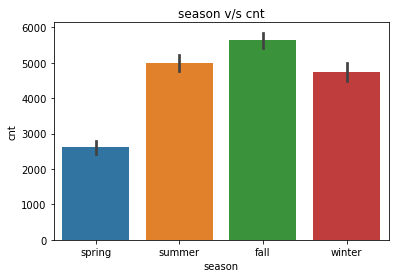

In [20]:
sns.barplot(x="season", y="cnt", data=df)
plt.title("season v/s cnt")
plt.show()

- fall has highest number of customers followed by summer

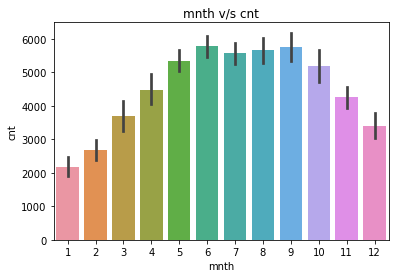

In [21]:
sns.barplot(x="mnth", y="cnt", data=df)
plt.title("mnth v/s cnt")
plt.show()

- mnth also tells us that from june to september, the sale is higest

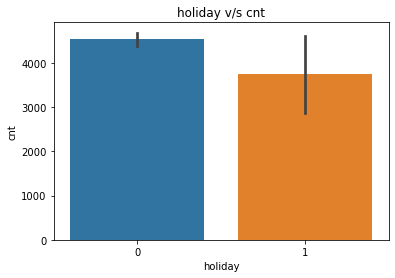

In [22]:
sns.barplot(x="holiday", y="cnt", data=df)
plt.title("holiday v/s cnt")
plt.show()

- above graph tells us that on holiday, people tend to stay more at home

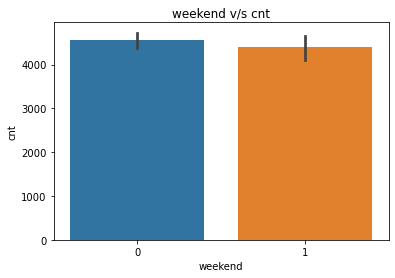

In [23]:
sns.barplot(x="weekend", y="cnt", data=df)
plt.title("weekend v/s cnt")
plt.show()

- weekend does not seem to affect the usage of bikes

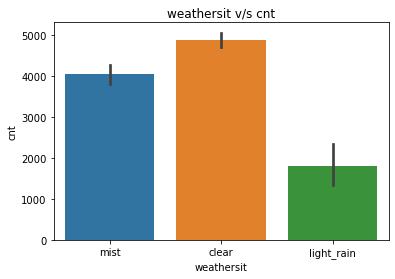

In [24]:
sns.barplot(x="weathersit", y="cnt", data=df)
plt.title("weathersit v/s cnt")
plt.show()

- more people use bikes on a clear weather, which is obvious

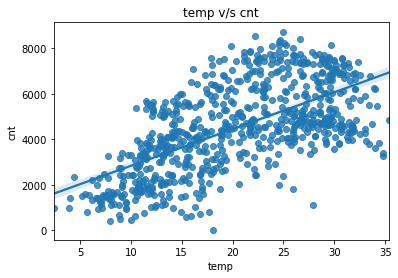

In [25]:
sns.regplot(x="temp", y="cnt", data=df)
plt.title("temp v/s cnt")
plt.show()

- they seem to be somewhat linearly correlated but temp is able to capture very less variance in cnt but it should definitely be used as a predictor

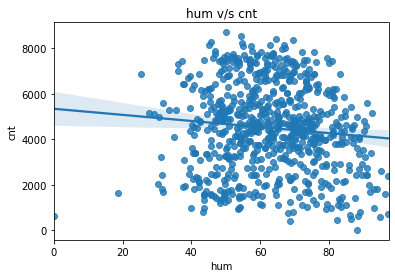

In [26]:
sns.regplot(x="hum", y="cnt", data=df)
plt.title("hum v/s cnt")
plt.show()

- hum seems to be less related to cnt as compared to temp

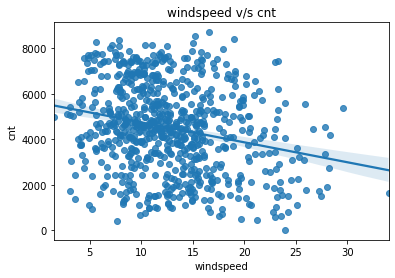

In [27]:
sns.regplot(x="windspeed", y="cnt", data=df)
plt.title("windspeed v/s cnt")
plt.show()

- windspeed looks very similar to hum

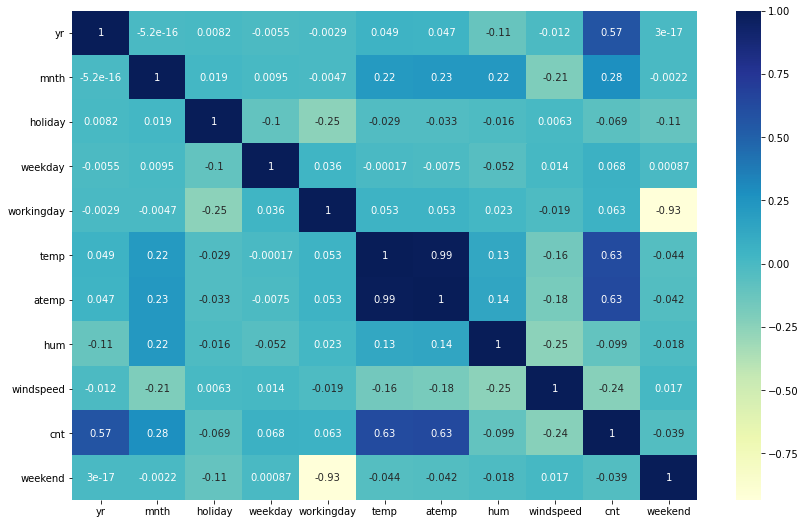

In [28]:
plt.figure(figsize=(14, 9))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")
plt.show()

- temp has highest correlation with the target variable

#### Dummy variables creation

In [29]:
df = pd.get_dummies(df, drop_first=True)

In [30]:
df.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,weekend,season_spring,season_summer,season_winter,weathersit_light_rain,weathersit_mist
0,0,1,0,6,0,14.110847,18.18125,80.5833,10.749882,985,1,1,0,0,0,1
1,0,1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,1,0,0,0,1
2,0,1,0,1,1,8.050924,9.47025,43.7273,16.636703,1349,0,1,0,0,0,0
3,0,1,0,2,1,8.200000,10.60610,59.0435,10.739832,1562,0,1,0,0,0,0
4,0,1,0,3,1,9.305237,11.46350,43.6957,12.522300,1600,0,1,0,0,0,0


In [31]:
df.shape

(730, 16)

#### Train Test Split
- we are going to divide df_1 into training and testing data with training data having 75 % of total data

In [32]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, train_size=0.75, random_state=123)

In [33]:
train_df.shape

(547, 16)

#### Normalization
- let's use normalization because all the other values are also between 0 and 1

In [34]:
train_df.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,weekend,season_spring,season_summer,season_winter,weathersit_light_rain,weathersit_mist
102,0,4,0,3,1,16.912500,20.86415,81.9167,16.791339,2162,0,0,1,0,0,1
715,1,12,0,1,1,16.126653,20.07500,90.7083,6.583306,4585,0,0,0,1,0,1
538,1,6,0,6,0,29.998347,32.63960,53.4583,12.041307,7458,1,0,0,0,0,0
729,1,12,0,1,1,8.849153,11.17435,57.7500,10.374682,2729,0,1,0,0,0,1
399,1,2,0,6,0,10.830847,13.63625,77.9583,8.167032,2832,1,1,0,0,0,1


In [35]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

num_cols = ["mnth", "weekday", "temp", "atemp", "hum", "windspeed"]

train_df[num_cols] = sc.fit_transform(train_df[num_cols])

train_df.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,weekend,season_spring,season_summer,season_winter,weathersit_light_rain,weathersit_mist
102,0,0.272727,0,0.500000,1,0.440316,0.452580,0.842331,0.470498,2162,0,0,1,0,0,1
715,1,1.000000,0,0.166667,1,0.416433,0.431460,0.932733,0.156403,4585,0,0,0,1,0,1
538,1,0.454545,0,1.000000,0,0.838014,0.767726,0.549700,0.324343,7458,1,0,0,0,0,0
729,1,1.000000,0,0.166667,1,0.195259,0.193252,0.593830,0.273062,2729,0,1,0,0,0,1
399,1,0.090909,0,1.000000,0,0.255486,0.259140,0.801628,0.205133,2832,1,1,0,0,0,1


In [36]:
test_df[num_cols] = sc.transform(test_df[num_cols])

test_df.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,weekend,season_spring,season_summer,season_winter,weathersit_light_rain,weathersit_mist
591,1,0.636364,0,0.500000,1,0.806862,0.769392,0.637103,0.303830,7347,0,0,0,0,0,0
455,1,0.272727,0,0.000000,0,0.456929,0.452585,0.695373,0.308976,6041,1,0,1,0,0,1
226,0,0.636364,0,0.166667,1,0.755981,0.718716,0.732219,0.384608,4338,0,0,0,0,0,0
131,0,0.363636,0,0.666667,1,0.592957,0.594530,0.768638,0.344847,4864,0,0,1,0,0,0
232,0,0.636364,0,0.000000,0,0.812053,0.798146,0.791774,0.466658,3873,1,0,0,0,0,0


- let's rearrange the columns to get the target at the end and then the preparation of predictors and target variables will be easier

In [37]:
train_df.columns

Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'cnt', 'weekend', 'season_spring', 'season_summer',
       'season_winter', 'weathersit_light_rain', 'weathersit_mist'],
      dtype='object')

In [38]:
rearranged_cols = ['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'weekend', 'season_spring', 'season_summer',
       'season_winter', 'weathersit_light_rain', 'weathersit_mist', 'cnt']

In [39]:
# rearranging columns for convinience

train_df = train_df[rearranged_cols]
test_df = test_df[rearranged_cols]

#### Independent and Dependent variables creation

In [40]:
x_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
x_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

In [41]:
x_train.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,weekend,season_spring,season_summer,season_winter,weathersit_light_rain,weathersit_mist
102,0,0.272727,0,0.500000,1,0.440316,0.452580,0.842331,0.470498,0,0,1,0,0,1
715,1,1.000000,0,0.166667,1,0.416433,0.431460,0.932733,0.156403,0,0,0,1,0,1
538,1,0.454545,0,1.000000,0,0.838014,0.767726,0.549700,0.324343,1,0,0,0,0,0
729,1,1.000000,0,0.166667,1,0.195259,0.193252,0.593830,0.273062,0,1,0,0,0,1
399,1,0.090909,0,1.000000,0,0.255486,0.259140,0.801628,0.205133,1,1,0,0,0,1


In [42]:
x_train.shape

(547, 15)

- now, the dataset is ready to be trained upon, let's proceed to train and evaluate the model

### Model Building

#### Approach:-
- train the model with all the available data using statsmodels
- check the p-values and vif scores of variables
- drop the variable based on the above two parameters
- keep dropping till you achieve a robust model which does not have multicollinearity and there's no extra variable

*Since we only have 15 predictors so we are not using RFE to narrow down the number of columns even further*

In [43]:
import statsmodels.api as sm

x_train_sm = sm.add_constant(x_train)

In [44]:
lr = sm.OLS(y_train, x_train_sm)

lr = lr.fit()

lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     201.8
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          3.04e-202
Time:                        02:44:11   Log-Likelihood:                -4424.0
No. Observations:                 547   AIC:                             8878.
Df Residuals:                     532   BIC:                             8943.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1725.2264    247.379      6.974      0.000    1239.266    2211.187
yr                     1979.9453     69.983     28.292      0.000    1842.469    2117.422
mnth                   -357.2147    196.197     -1.821      0.069    -742.630      28.201
holiday                 252.9190    163.334      1.548      0.122     -67.941     573.779
weekday                 454.3460    104.279      4.357      0.000     249.498     659.194
workingday              799.9281     97.706      8.187      0.000     607.992     991.864
temp                   3318.4414   1167.351      2.843      0.005    1025.258    5611.625
atemp                  1199.2337   1178.184      1.018      0.309   -1115.229    3513.697
hum                   -1215.1363    326.594     -3.721      0.000   -1856.709    -573.564
windspeed             -1363.5197    246.112     -5.540      0.000   -1846.991    -880.049
weekend                 672.3793    104.616      6.427      0.000     466.868     877.891
season_spring          -920.9957    186.185     -4.947      0.000   -1286.744    -555.247
season_summer           186.1846    126.998      1.466      0.143     -63.294     435.663
season_winter           842.3409    150.833      5.585      0.000     546.039    1138.643
weathersit_light_rain -1815.6746    224.240     -8.097      0.000   -2256.178   -1375.171
weathersit_mist        -409.2368     91.557     -4.470      0.000    -589.095    -229.378
==============================================================================
Omnibus:                       71.527   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.223
Skew:                          -0.692   Prob(JB):                     1.09e-37
Kurtosis:                       5.356   Cond. No.                     6.67e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.59e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [45]:
# lets make a function to check vif 

from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["VIF"] = round(vif["VIF"], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    return vif

In [46]:
get_vif(x_train)

,Features,VIF
4,workingday,60.89
5,temp,59.72
6,atemp,55.77
9,weekend,26.57
10,season_spring,5.87
2,holiday,4.19
12,season_winter,3.56
1,mnth,3.40
11,season_summer,2.62
7,hum,1.98


- 'atemp' has high vif and high p-value so lets drop it

In [47]:
x_train.columns

Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'weekend', 'season_spring', 'season_summer',
       'season_winter', 'weathersit_light_rain', 'weathersit_mist'],
      dtype='object')

In [48]:
cols = ['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp',
       'hum', 'windspeed', 'weekend', 'season_spring', 'season_summer',
       'season_winter', 'weathersit_light_rain', 'weathersit_mist']

In [49]:
x_train_sm = sm.add_constant(x_train[cols])

lr_1 = sm.OLS(y_train, x_train_sm)

lr_1 = lr_1.fit()

lr_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     217.2
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          3.39e-203
Time:                        02:44:12   Log-Likelihood:                -4424.5
No. Observations:                 547   AIC:                             8877.
Df Residuals:                     533   BIC:                             8937.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1727.6286    247.377      6.984      0.000    1241.676    2213.581
yr                     1978.4945     69.971     28.276      0.000    1841.043    2115.946
mnth                   -358.4853    196.199     -1.827      0.068    -743.904      26.934
holiday                 248.2080    163.274      1.520      0.129     -72.532     568.948
weekday                 446.6115    104.005      4.294      0.000     242.302     650.921
workingday              803.6691     97.640      8.231      0.000     611.863     995.475
temp                   4472.3778    278.353     16.067      0.000    3925.575    5019.180
hum                   -1203.9769    326.421     -3.688      0.000   -1845.207    -562.747
windspeed             -1413.9846    241.075     -5.865      0.000   -1887.558    -940.411
weekend                 675.7515    104.567      6.462      0.000     470.337     881.166
season_spring          -902.8017    185.331     -4.871      0.000   -1266.871    -538.732
season_summer           208.0755    125.168      1.662      0.097     -37.807     453.958
season_winter           868.3681    148.655      5.841      0.000     576.346    1160.390
weathersit_light_rain -1821.7480    224.168     -8.127      0.000   -2262.109   -1381.387
weathersit_mist        -408.7845     91.559     -4.465      0.000    -588.646    -228.923
==============================================================================
Omnibus:                       69.248   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.848
Skew:                          -0.671   Prob(JB):                     1.60e-36
Kurtosis:                       5.330   Cond. No.                     4.08e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.14e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [50]:
get_vif(x_train_sm)

,Features,VIF
3,holiday,inf
5,workingday,inf
9,weekend,inf
10,season_spring,5.82
12,season_winter,3.45
2,mnth,3.40
6,temp,3.40
11,season_summer,2.55
7,hum,1.98
14,weathersit_mist,1.56


- 'holiday' has high vif and p-value so let's drop it

In [51]:
cols = ['yr', 'mnth', 'weekday', 'workingday', 'temp',
       'hum', 'windspeed', 'weekend', 'season_spring', 'season_summer',
       'season_winter', 'weathersit_light_rain', 'weathersit_mist']

In [52]:
x_train_sm = sm.add_constant(x_train[cols])

lr = sm.OLS(y_train, x_train_sm)

lr = lr.fit()

lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     217.2
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          3.39e-203
Time:                        02:44:12   Log-Likelihood:                -4424.5
No. Observations:                 547   AIC:                             8877.
Df Residuals:                     533   BIC:                             8937.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1975.8367    374.990      5.269      0.000    1239.198    2712.475
yr                     1978.4945     69.971     28.276      0.000    1841.043    2115.946
mnth                   -358.4853    196.199     -1.827      0.068    -743.904      26.934
weekday                 446.6115    104.005      4.294      0.000     242.302     650.921
workingday              555.4611    189.756      2.927      0.004     182.699     928.223
temp                   4472.3778    278.353     16.067      0.000    3925.575    5019.180
hum                   -1203.9769    326.421     -3.688      0.000   -1845.207    -562.747
windspeed             -1413.9846    241.075     -5.865      0.000   -1887.558    -940.411
weekend                 427.5435    195.783      2.184      0.029      42.942     812.145
season_spring          -902.8017    185.331     -4.871      0.000   -1266.871    -538.732
season_summer           208.0755    125.168      1.662      0.097     -37.807     453.958
season_winter           868.3681    148.655      5.841      0.000     576.346    1160.390
weathersit_light_rain -1821.7480    224.168     -8.127      0.000   -2262.109   -1381.387
weathersit_mist        -408.7845     91.559     -4.465      0.000    -588.646    -228.923
==============================================================================
Omnibus:                       69.248   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.848
Skew:                          -0.671   Prob(JB):                     1.60e-36
Kurtosis:                       5.330   Cond. No.                         26.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
get_vif(x_train_sm)

,Features,VIF
0,const,120.64
4,workingday,6.74
8,weekend,6.73
9,season_spring,5.82
11,season_winter,3.45
2,mnth,3.40
5,temp,3.40
10,season_summer,2.55
6,hum,1.98
13,weathersit_mist,1.56


- 'season_summer' has high p-value so let's drop it

In [54]:
cols = ['yr', 'mnth', 'weekday', 'workingday', 'temp',
       'hum', 'windspeed', 'weekend', 'season_spring',
       'season_winter', 'weathersit_light_rain', 'weathersit_mist']

In [55]:
x_train_sm = sm.add_constant(x_train[cols])

lr = sm.OLS(y_train, x_train_sm)

lr = lr.fit()

lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     234.3
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          8.55e-204
Time:                        02:44:12   Log-Likelihood:                -4425.9
No. Observations:                 547   AIC:                             8878.
Df Residuals:                     534   BIC:                             8934.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2227.2313    343.710      6.480      0.000    1552.042    2902.421
yr                     1985.9392     69.942     28.394      0.000    1848.543    2123.335
mnth                   -497.7267    177.714     -2.801      0.005    -846.831    -148.622
weekday                 451.0642    104.142      4.331      0.000     246.486     655.642
workingday              547.2122    190.004      2.880      0.004     173.964     920.460
temp                   4273.6832    251.799     16.973      0.000    3779.045    4768.321
hum                   -1128.7180    323.800     -3.486      0.001   -1764.796    -492.640
windspeed             -1365.2295    239.679     -5.696      0.000   -1836.059    -894.400
weekend                 417.6113    196.015      2.131      0.034      32.556     802.666
season_spring         -1126.2672    127.794     -8.813      0.000   -1377.307    -875.227
season_winter           771.5582    136.999      5.632      0.000     502.435    1040.681
weathersit_light_rain -1856.6876    223.549     -8.306      0.000   -2295.830   -1417.545
weathersit_mist        -417.5705     91.558     -4.561      0.000    -597.428    -237.713
==============================================================================
Omnibus:                       70.749   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.510
Skew:                          -0.683   Prob(JB):                     1.55e-37
Kurtosis:                       5.360   Cond. No.                         25.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
get_vif(x_train_sm)

,Features,VIF
0,const,101.02
4,workingday,6.74
8,weekend,6.72
10,season_winter,2.92
2,mnth,2.78
5,temp,2.77
9,season_spring,2.76
6,hum,1.94
12,weathersit_mist,1.56
11,weathersit_light_rain,1.36


- let's drop 'weekend' due to high vif and more p - value compared to 'workingday'

In [57]:
cols = ['yr', 'mnth', 'weekday', 'workingday', 'temp',
       'hum', 'windspeed', 'season_spring',
       'season_winter', 'weathersit_light_rain', 'weathersit_mist']

In [58]:
x_train_sm = sm.add_constant(x_train[cols])

lr = sm.OLS(y_train, x_train_sm)

lr = lr.fit()

lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     253.5
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          4.98e-204
Time:                        02:44:13   Log-Likelihood:                -4428.2
No. Observations:                 547   AIC:                             8880.
Df Residuals:                     535   BIC:                             8932.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2604.8657    295.453      8.817      0.000    2024.476    3185.256
yr                     1986.3658     70.173     28.307      0.000    1848.517    2124.214
mnth                   -509.1420    178.220     -2.857      0.004    -859.239    -159.045
weekday                 477.9339    103.717      4.608      0.000     274.192     681.676
workingday              174.0765     73.917      2.355      0.019      28.872     319.280
temp                   4264.9785    252.597     16.885      0.000    3768.775    4761.182
hum                   -1132.9434    324.863     -3.487      0.001   -1771.107    -494.780
windspeed             -1373.3625    240.440     -5.712      0.000   -1845.685    -901.040
season_spring         -1135.6304    128.140     -8.862      0.000   -1387.350    -883.911
season_winter           771.3222    137.451      5.612      0.000     501.312    1041.333
weathersit_light_rain -1845.7541    224.228     -8.232      0.000   -2286.229   -1405.279
weathersit_mist        -418.7950     91.858     -4.559      0.000    -599.242    -238.348
==============================================================================
Omnibus:                       73.739   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.416
Skew:                          -0.692   Prob(JB):                     3.31e-41
Kurtosis:                       5.502   Cond. No.                         23.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
get_vif(x_train_sm)

,Features,VIF
0,const,74.16
9,season_winter,2.92
2,mnth,2.78
5,temp,2.77
8,season_spring,2.75
6,hum,1.94
11,weathersit_mist,1.56
10,weathersit_light_rain,1.36
7,windspeed,1.23
1,yr,1.05


- Now, the model has no column having more than vif of 3 and the p-values are also pretty normal.

### Residual Analysis

Linear Regression comes with assumptions about the data:-
   1. linear relationship between predictor(s) variable and target variable
   2. error terms have constant variance
   3. error terms should be normally distributed
   4. independent variables should not be correlated

*First relationship is discovered using linear regression, second and third will be tested now and the last one was taken care of by eliminating variables with high VIF*

In [60]:
y_train_pred = lr.predict(x_train_sm)

res = y_train - y_train_pred

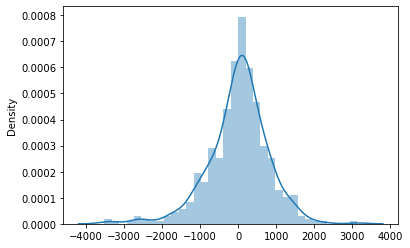

In [61]:
sns.distplot(res)
plt.show()

- The distribution of error terms(res) is normal
- *3rd assumption proved*

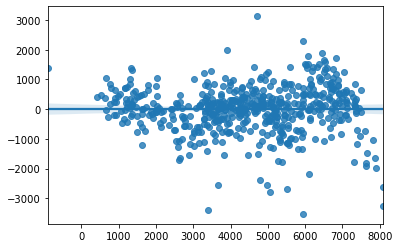

In [62]:
sns.regplot(x=y_train_pred, y=res)
plt.show()

- the residuals are centered around zero and have a more or less constant variance with little more spread later on
- the distribution should not have any obvious patterns which is also true for the above plot
- *2nd assumption also proved*

### Evaluation

In [63]:
x_test_sm = sm.add_constant(x_test[cols])

y_test_pred = lr.predict(x_test_sm)

In [64]:
# Calculating r2 score on the test data

from sklearn.metrics import r2_score

print("R2 score on train data =", 0.839)
print("R2 Score on test data =", round(r2_score(y_true=y_test, y_pred=y_test_pred), 3))

R2 score on train data = 0.839
R2 Score on test data = 0.765


### Way Forward

According to absolute values of coefficients, three most significant variables for prediction of 'cnt' are:-
1. temp (+)
2. yr (+)
3. weathersit_light_rain (-)

Observation:-
- people tend to use bikes when it is relatively hot
- the popularity of the company is growing with time
- when there is rain, less people tend to use bikes.

Conclusions:-
- Company can offer discounts in winters
- Marketing budget can be allocated/better utilized for more promotion